In [1]:
!pip install nltk
!pip install gensim

In [2]:
import pandas as pd
import numpy as np
import sklearn
import gensim
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
import os
import re
from html.parser import HTMLParser

In [3]:
with open('./prepared.pickle', 'rb') as f:
    df = pickle.load(f)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49159 entries, 0 to 49158
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    49159 non-null  int64  
 1   label                 31962 non-null  float64
 2   tweet                 49159 non-null  object 
 3   clean_tweet           49159 non-null  object 
 4   tweet_token           49159 non-null  object 
 5   tweet_token_filtered  49159 non-null  object 
 6   tweet_stemmed         49159 non-null  object 
 7   tweet_lemmatized      49159 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 3.0+ MB


In [5]:
df.head()

,id,label,tweet,clean_tweet,tweet_token,tweet_token_filtered,tweet_stemmed,tweet_lemmatized
0,1,0.0,@user when a father is dysfunctional and is s...,when father is dysfunctional and is so selfish...,"[when, father, is, dysfunctional, and, is, so,...","[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunct, selfish, drag, kid, dysfunc...","[father, dysfunctional, selfish, drag, kid, dy..."
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit cannot use cause they d...,"[thanks, for, lyft, credit, can, not, use, cau...","[thanks, lyft, credit, use, cause, offer, whee...","[thank, lyft, credit, use, caus, offer, wheelc...","[thanks, lyft, credit, use, cause, offer, whee..."
2,3,0.0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]","[bihday, majesti]","[bihday, majesty]"
3,4,0.0,#model i love u take with u all the time in ...,model love you take with you all the time in urð,"[model, love, you, take, with, you, all, the, ...","[model, love, take, time, urð]","[model, love, take, time, urð]","[model, love, take, time, urð]"
4,5,0.0,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, now, motivation]","[factsguide, society, motivation]","[factsguid, societi, motiv]","[factsguide, society, motivation]"


1. Создайте мешок слов с помощью sklearn.feature_extraction.text.CountVectorizer.fit_transform().  
Применим его к 'tweet_stemmed' и 'tweet_lemmatized' отдельно.


- Игнорируем слова, частота которых в документе строго превышает порог 0.9 с помощью max_df.
- Ограничим количество слов, попадающий в мешок, с помощью max_features = 1000.
- Исключим стоп-слова с помощью stop_words='english'.
- Отобразим Bag-of-Words модель как DataFrame. columns необходимо извлечь с помощью CountVectorizer.get_feature_names().


In [6]:
count_bow_vectorizer = sklearn.feature_extraction.text.CountVectorizer(max_df=0.90, max_features=1000, stop_words='english')

In [7]:
tw_st_all = np.array([item for sublist in df['tweet_stemmed'] for item in sublist])

In [8]:
bow_stemmed = count_bow_vectorizer.fit_transform(tw_st_all)
count_bow_stemmed = pd.DataFrame.sparse.from_spmatrix(columns=count_bow_vectorizer.get_feature_names(), data=bow_stemmed)

In [9]:
tw_lem_all = np.array([item for sublist in df['tweet_lemmatized'] for item in sublist])

In [10]:
bow_lemma = count_bow_vectorizer.fit_transform(tw_lem_all)
count_bow_lemma = pd.DataFrame.sparse.from_spmatrix(columns=count_bow_vectorizer.get_feature_names(), data=bow_lemma)

2. Создайте мешок слов с помощью sklearn.feature_extraction.text.TfidfVectorizer.fit_transform(). Применим его к 'tweet_stemmed' и 'tweet_lemmatized' отдельно.  


- Игнорируем слова, частота которых в документе строго превышает порог 0.9 с помощью max_df.
- Ограничим количество слов, попадающий в мешок, с помощью max_features = 1000.
- Исключим стоп-слова с помощью stop_words='english'.
- Отобразим Bag-of-Words модель как DataFrame. columns необходимо извлечь с помощью TfidfVectorizer.get_feature_names().


In [11]:
tfidf_bow_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.90, max_features=1000, stop_words='english')

In [12]:
bow_stemmed = tfidf_bow_vectorizer.fit_transform(tw_st_all)
tfidf_bow_stemmed = pd.DataFrame.sparse.from_spmatrix(columns=tfidf_bow_vectorizer.get_feature_names(), data=bow_stemmed)

In [13]:
bow_lemma = count_bow_vectorizer.fit_transform(tw_lem_all)
tfidf_bow_lemma = pd.DataFrame.sparse.from_spmatrix(columns=tfidf_bow_vectorizer.get_feature_names(), data=bow_lemma)

3. Натренируем gensim.models.Word2Vec модель на наших данных.  
Тренировать будем на токенизированных твитах combine_df['tweet_token']  


- Установим следующие параметры: size=200, window=5, min_count=2, sg = 1, hs = 0, negative = 10, workers= 32, seed = 34.
- Используем функцию train() с параметром total_examples равным длине combine_df['tweet_token'], количество epochs установим 20.


In [14]:
from gensim.models import Word2Vec

In [15]:
w2v_vectorizer = Word2Vec(corpus_file='./corpus', size=200, window=5, min_count=1, sg=1, hs=0, negative=10, workers=32, seed=34)

In [16]:
w2v_vectorizer.train(df['tweet_token'], total_examples=df['tweet_token'].shape[0], epochs=20)

(7958411, 11782200)

In [17]:
w2v_vectorizer.save('w2v_vectorizer.model')

4. Давайте немного потестируем нашу модель Word2Vec и посмотрим, как она работает. Мы зададим слово positive = "dinner", и модель вытащит из корпуса наиболее похожие слова c помощью функции most_similar. То же самое попробуем со словом "trump".

In [18]:
w2v_vectorizer.most_similar(positive="dinner")

[('pasta', 0.6841076016426086),
 ('pancakes', 0.6751857995986938),
 ('salsa', 0.6703296899795532),
 ('candlelight', 0.6688082218170166),
 ('lunch', 0.6660800576210022),
 ('showers', 0.6659550666809082),
 ('spiral', 0.6636358499526978),
 ('cork', 0.6632431149482727),
 ('favs', 0.6604034900665283),
 ('smoothie', 0.6599393486976624)]

In [19]:
w2v_vectorizer.most_similar("trump")

[('slammed', 0.6073219776153564),
 ('Leonard', 0.5960643291473389),
 ('fail.', 0.5952973365783691),
 ('inviting', 0.5939775705337524),
 ('Garnell', 0.5925332903862),
 ('"get"', 0.5920398831367493),
 ('Pinth', 0.5918149352073669),
 ('interventions', 0.5918017625808716),
 ('Woody', 0.5916659832000732),
 ('Firemen', 0.590410053730011)]

5. Из приведенных выше примеров мы видим, что наша модель word2vec хорошо справляется с поиском наиболее похожих слов для данного слова. Но как она это делает? Она изучила векторы для каждого уникального слова наших данных и использует косинусное сходство, чтобы найти наиболее похожие векторы (слова).
Давайте проверим векторное представление любого слова из нашего корпуса, например "food".

In [20]:
from sklearn.manifold import TSNE

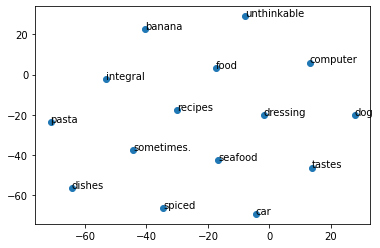

In [21]:
word = 'food'
model = w2v_vectorizer

arr = np.empty((0,200), dtype='f')
word_labels = [word]

close_words = model.similar_by_word(word)
not_close_words = ['dog', 'banana', 'car', 'computer']

arr = np.append(arr, np.array([model[word]]), axis=0)
for wrd_score in close_words:
    wrd_vector = model[wrd_score[0]]
    word_labels.append(wrd_score[0])
    arr = np.append(arr, np.array([wrd_vector]), axis=0)
    
for wrd in not_close_words:
    wrd_vector = model[wrd]
    word_labels.append(wrd)
    arr = np.append(arr, np.array([wrd_vector]), axis=0)

tsne = TSNE(n_components=2, random_state=42)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(arr)

x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords)

for label, x, y in zip(word_labels, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
# plt.xlim(x_coords.min()+0.5, x_coords.max()+0.5)
# plt.ylim(y_coords.min()+0.5, y_coords.max()+0.5)
plt.show()

**.. почему так плохо?**

6. Поскольку наши данные содержат твиты, а не только слова, нам придется придумать способ использовать векторы слов из модели word2vec для создания векторного представления всего твита. Существует простое решение этой проблемы, мы можем просто взять среднее значение всех векторов слов, присутствующих в твите. Длина результирующего вектора будет одинаковой, то есть 200. Мы повторим тот же процесс для всех твитов в наших данных и получим их векторы. Теперь у нас есть 200 функций word2vec для наших данных.
Необходимо создать вектор для каждого твита, взяв среднее значение векторов слов, присутствующих в твите. В цикле сделать:  vec += model_w2v[word].reshape((1, size))
и поделить финальный вектор на количество слов в твите.
На выходе должен получиться wordvec_df.shape = (49159, 200).

In [29]:
data = []

for i in range(df['tweet_token_filtered'].shape[0]):
    vec = []

    for word in df['tweet_token_filtered'][0]:
        try:
            vec.append(model[word])
        except:
            pass
        
    np_vec = np.array(vec)
    data.append(list(np_vec.sum(axis=0)/np_vec.shape[0]))

In [31]:
np.array(data).shape

(49159, 200)

In [32]:
columns=[x for x in range(200)]
wordvec_df = pd.DataFrame(data, columns=columns)

In [34]:
wordvec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.710511,-0.068873,0.30613,0.102179,0.171617,0.313152,0.170175,-0.194134,0.152823,-0.020243,...,-0.11687,0.194347,0.039535,-0.077486,0.528871,0.290712,-0.280655,-0.0071,-0.370079,-0.332591
1,0.710511,-0.068873,0.30613,0.102179,0.171617,0.313152,0.170175,-0.194134,0.152823,-0.020243,...,-0.11687,0.194347,0.039535,-0.077486,0.528871,0.290712,-0.280655,-0.0071,-0.370079,-0.332591
2,0.710511,-0.068873,0.30613,0.102179,0.171617,0.313152,0.170175,-0.194134,0.152823,-0.020243,...,-0.11687,0.194347,0.039535,-0.077486,0.528871,0.290712,-0.280655,-0.0071,-0.370079,-0.332591
3,0.710511,-0.068873,0.30613,0.102179,0.171617,0.313152,0.170175,-0.194134,0.152823,-0.020243,...,-0.11687,0.194347,0.039535,-0.077486,0.528871,0.290712,-0.280655,-0.0071,-0.370079,-0.332591
4,0.710511,-0.068873,0.30613,0.102179,0.171617,0.313152,0.170175,-0.194134,0.152823,-0.020243,...,-0.11687,0.194347,0.039535,-0.077486,0.528871,0.290712,-0.280655,-0.0071,-0.370079,-0.332591
